In [6]:
from statsmodels.tsa.api import ExponentialSmoothing, SARIMAX, seasonal_decompose
import statsmodels
import pandas as pd
import numpy as np
import datetime
from sklearn import metrics

In [57]:
df = pd.read_csv('web-traffic.csv')
df.shape

(2167, 8)

In [58]:
df.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236


## UNIVARIATE MODEL
#### Preprocess

In [9]:
for i in range(0, len(df)):
    df['Page.Loads'].iloc[i] = int(df['Page.Loads'].iloc[i].replace(',',''))
    df['Unique.Visits'].iloc[i] = int(df['Unique.Visits'].iloc[i].replace(',',''))
    df['First.Time.Visits'].iloc[i] = int(df['First.Time.Visits'].iloc[i].replace(',',''))
    df['Returning.Visits'].iloc[i] = int(df['Returning.Visits'].iloc[i].replace(',',''))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [59]:
def preprocess(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.fillna(method='ffill', inplace=True)
    
    for i in range(0, len(df)):
        df['Page.Loads'].iloc[i] = int(df['Page.Loads'].iloc[i].replace(',',''))
        df['Unique.Visits'].iloc[i] = int(df['Unique.Visits'].iloc[i].replace(',',''))
        df['First.Time.Visits'].iloc[i] = int(df['First.Time.Visits'].iloc[i].replace(',',''))
        df['Returning.Visits'].iloc[i] = int(df['Returning.Visits'].iloc[i].replace(',',''))

    return df

In [60]:
df = preprocess(df)
start_training = datetime.datetime(2015, 1, 1)
end_training = datetime.datetime(2019, 12, 30)

ix1 = df[df['Date'] == start_training].index[0]
ix2 = df[df['Date'] == end_training].index[0]

df_un = df[['Date', 'Page.Loads']]
df_train = df_un.iloc[ix1:ix2,:]
df_test = df_un.iloc[ix2:,:]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [61]:
df_se = df.copy()
df_se.index = df['Date']
dec_result = seasonal_decompose(df_se['Page.Loads'])

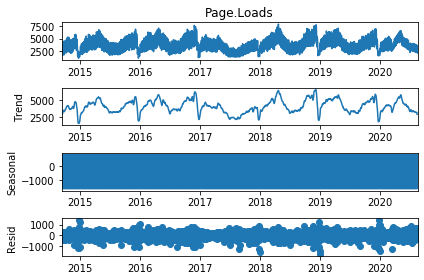

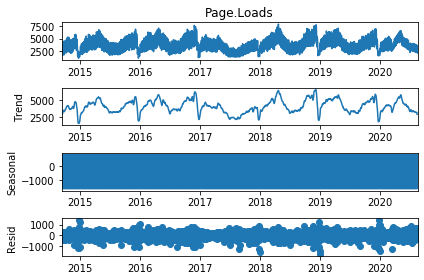

In [62]:
dec_result.plot()

### Forecasting page loads as an univariate variable using
- Exponential Smoothing
- SARIMAX

#### One time forecast

In [23]:
%%time
model = SARIMAX(np.asarray(df_train['Page.Loads']),order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()
preds = model_fit.forecast(len(df_test))
df_test['preds'] = preds

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CPU times: user 15.9 s, sys: 234 ms, total: 16.1 s
Wall time: 14.6 s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
mae = metrics.median_absolute_error(df_test['Page.Loads'], df_test['preds'])
print("mae", mae)

mae 1092.601465086528


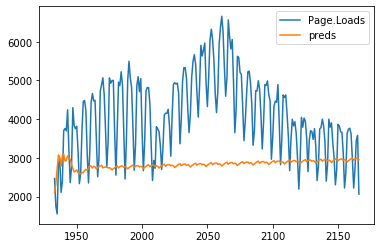

In [25]:
df_test[['Page.Loads','preds']].plot()

In [26]:
def rolling_forecast_sarimax(df, df_test, p):
    df_test['preds'] = 0
    for k in range(0, int(len(df_test)/p)):
        model = SARIMAX(np.asarray(df_train['Page.Loads']),order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        model_fit = model.fit()
        preds = model_fit.forecast(p)
        print(str(k) + 'th week')

        print("train-start-date:", df['Date'].iloc[0])
        print("train-end-date:", df['Date'].iloc[ix2+(k)*p])

        print('forecast-start-date:', df_test['Date'].iloc[(k)*p])
        print('forecast-end-date:', df_test['Date'].iloc[(k+1)*p])

        df_test['preds'].iloc[(k)*p:(k+1)*p] = preds
    
    return df_test

In [28]:
sar_ow = rolling_forecast_sarimax(df, df_test, 7)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2019-12-30 00:00:00
forecast-start-date: 2019-12-30 00:00:00
forecast-end-date: 2020-01-06 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-01-06 00:00:00
forecast-start-date: 2020-01-06 00:00:00
forecast-end-date: 2020-01-13 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-01-13 00:00:00
forecast-start-date: 2020-01-13 00:00:00
forecast-end-date: 2020-01-20 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-01-20 00:00:00
forecast-start-date: 2020-01-20 00:00:00
forecast-end-date: 2020-01-27 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-01-27 00:00:00
forecast-start-date: 2020-01-27 00:00:00
forecast-end-date: 2020-02-03 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-02-03 00:00:00
forecast-start-date: 2020-02-03 00:00:00
forecast-end-date: 2020-02-10 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


6th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-02-10 00:00:00
forecast-start-date: 2020-02-10 00:00:00
forecast-end-date: 2020-02-17 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


7th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-02-17 00:00:00
forecast-start-date: 2020-02-17 00:00:00
forecast-end-date: 2020-02-24 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


8th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-02-24 00:00:00
forecast-start-date: 2020-02-24 00:00:00
forecast-end-date: 2020-03-02 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


9th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-03-02 00:00:00
forecast-start-date: 2020-03-02 00:00:00
forecast-end-date: 2020-03-09 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


10th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-03-09 00:00:00
forecast-start-date: 2020-03-09 00:00:00
forecast-end-date: 2020-03-16 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


11th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-03-16 00:00:00
forecast-start-date: 2020-03-16 00:00:00
forecast-end-date: 2020-03-23 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


12th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-03-23 00:00:00
forecast-start-date: 2020-03-23 00:00:00
forecast-end-date: 2020-03-30 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


13th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-03-30 00:00:00
forecast-start-date: 2020-03-30 00:00:00
forecast-end-date: 2020-04-06 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


14th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-04-06 00:00:00
forecast-start-date: 2020-04-06 00:00:00
forecast-end-date: 2020-04-13 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


15th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-04-13 00:00:00
forecast-start-date: 2020-04-13 00:00:00
forecast-end-date: 2020-04-20 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


16th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-04-20 00:00:00
forecast-start-date: 2020-04-20 00:00:00
forecast-end-date: 2020-04-27 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


17th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-04-27 00:00:00
forecast-start-date: 2020-04-27 00:00:00
forecast-end-date: 2020-05-04 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


18th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-05-04 00:00:00
forecast-start-date: 2020-05-04 00:00:00
forecast-end-date: 2020-05-11 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


19th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-05-11 00:00:00
forecast-start-date: 2020-05-11 00:00:00
forecast-end-date: 2020-05-18 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


20th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-05-18 00:00:00
forecast-start-date: 2020-05-18 00:00:00
forecast-end-date: 2020-05-25 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


21th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-05-25 00:00:00
forecast-start-date: 2020-05-25 00:00:00
forecast-end-date: 2020-06-01 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


22th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-06-01 00:00:00
forecast-start-date: 2020-06-01 00:00:00
forecast-end-date: 2020-06-08 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


23th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-06-08 00:00:00
forecast-start-date: 2020-06-08 00:00:00
forecast-end-date: 2020-06-15 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


24th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-06-15 00:00:00
forecast-start-date: 2020-06-15 00:00:00
forecast-end-date: 2020-06-22 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


25th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-06-22 00:00:00
forecast-start-date: 2020-06-22 00:00:00
forecast-end-date: 2020-06-29 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


26th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-06-29 00:00:00
forecast-start-date: 2020-06-29 00:00:00
forecast-end-date: 2020-07-06 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


27th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-07-06 00:00:00
forecast-start-date: 2020-07-06 00:00:00
forecast-end-date: 2020-07-13 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


28th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-07-13 00:00:00
forecast-start-date: 2020-07-13 00:00:00
forecast-end-date: 2020-07-20 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


29th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-07-20 00:00:00
forecast-start-date: 2020-07-20 00:00:00
forecast-end-date: 2020-07-27 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


30th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-07-27 00:00:00
forecast-start-date: 2020-07-27 00:00:00
forecast-end-date: 2020-08-03 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


31th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-08-03 00:00:00
forecast-start-date: 2020-08-03 00:00:00
forecast-end-date: 2020-08-10 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


32th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-08-10 00:00:00
forecast-start-date: 2020-08-10 00:00:00
forecast-end-date: 2020-08-17 00:00:00


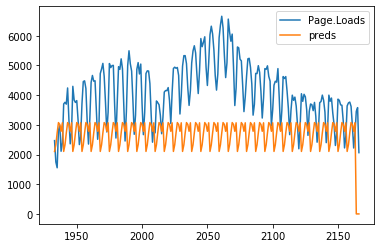

In [30]:
sar_ow[['Page.Loads', 'preds']].plot()

### Exponential Smoothing

In [40]:
def rolling_forecast_es(df, df_test, p):
    """
    Does rolling training and forecast for one week at a time 
    """
    
    df_test['preds'] = 0
    for k in range(0, int(len(df_test)/p)):
        model = ExponentialSmoothing(np.asarray(df['Page.Loads'].iloc[:ix2 + (k)*p]),seasonal_periods=365, seasonal='add', trend='add')
        model_fit = model.fit()
        preds = model_fit.forecast(p)
        print(str(k) + 'th week')

        print("train-start-date:", df['Date'].iloc[0])
        print("train-end-date:", df['Date'].iloc[ix2+(k)*p])

        print('forecast-start-date:', df_test['Date'].iloc[(k)*p])
        print('forecast-end-date:', df_test['Date'].iloc[(k+1)*p])

        df_test['preds'].iloc[(k)*p:(k+1)*p] = preds
    
    return df_test

In [54]:
df_ow_es = rolling_forecast_es(df, df_test, 7)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/ec2-use

0th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2019-12-30 00:00:00
forecast-start-date: 2019-12-30 00:00:00
forecast-end-date: 2020-01-06 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


1th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-01-06 00:00:00
forecast-start-date: 2020-01-06 00:00:00
forecast-end-date: 2020-01-13 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


2th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-01-13 00:00:00
forecast-start-date: 2020-01-13 00:00:00
forecast-end-date: 2020-01-20 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


3th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-01-20 00:00:00
forecast-start-date: 2020-01-20 00:00:00
forecast-end-date: 2020-01-27 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


4th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-01-27 00:00:00
forecast-start-date: 2020-01-27 00:00:00
forecast-end-date: 2020-02-03 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


5th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-02-03 00:00:00
forecast-start-date: 2020-02-03 00:00:00
forecast-end-date: 2020-02-10 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


6th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-02-10 00:00:00
forecast-start-date: 2020-02-10 00:00:00
forecast-end-date: 2020-02-17 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


7th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-02-17 00:00:00
forecast-start-date: 2020-02-17 00:00:00
forecast-end-date: 2020-02-24 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


8th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-02-24 00:00:00
forecast-start-date: 2020-02-24 00:00:00
forecast-end-date: 2020-03-02 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


9th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-03-02 00:00:00
forecast-start-date: 2020-03-02 00:00:00
forecast-end-date: 2020-03-09 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


10th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-03-09 00:00:00
forecast-start-date: 2020-03-09 00:00:00
forecast-end-date: 2020-03-16 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


11th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-03-16 00:00:00
forecast-start-date: 2020-03-16 00:00:00
forecast-end-date: 2020-03-23 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


12th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-03-23 00:00:00
forecast-start-date: 2020-03-23 00:00:00
forecast-end-date: 2020-03-30 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


13th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-03-30 00:00:00
forecast-start-date: 2020-03-30 00:00:00
forecast-end-date: 2020-04-06 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


14th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-04-06 00:00:00
forecast-start-date: 2020-04-06 00:00:00
forecast-end-date: 2020-04-13 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


15th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-04-13 00:00:00
forecast-start-date: 2020-04-13 00:00:00
forecast-end-date: 2020-04-20 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


16th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-04-20 00:00:00
forecast-start-date: 2020-04-20 00:00:00
forecast-end-date: 2020-04-27 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


17th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-04-27 00:00:00
forecast-start-date: 2020-04-27 00:00:00
forecast-end-date: 2020-05-04 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


18th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-05-04 00:00:00
forecast-start-date: 2020-05-04 00:00:00
forecast-end-date: 2020-05-11 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


19th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-05-11 00:00:00
forecast-start-date: 2020-05-11 00:00:00
forecast-end-date: 2020-05-18 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


20th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-05-18 00:00:00
forecast-start-date: 2020-05-18 00:00:00
forecast-end-date: 2020-05-25 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


21th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-05-25 00:00:00
forecast-start-date: 2020-05-25 00:00:00
forecast-end-date: 2020-06-01 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


22th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-06-01 00:00:00
forecast-start-date: 2020-06-01 00:00:00
forecast-end-date: 2020-06-08 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


23th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-06-08 00:00:00
forecast-start-date: 2020-06-08 00:00:00
forecast-end-date: 2020-06-15 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


24th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-06-15 00:00:00
forecast-start-date: 2020-06-15 00:00:00
forecast-end-date: 2020-06-22 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


25th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-06-22 00:00:00
forecast-start-date: 2020-06-22 00:00:00
forecast-end-date: 2020-06-29 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


26th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-06-29 00:00:00
forecast-start-date: 2020-06-29 00:00:00
forecast-end-date: 2020-07-06 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


27th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-07-06 00:00:00
forecast-start-date: 2020-07-06 00:00:00
forecast-end-date: 2020-07-13 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


28th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-07-13 00:00:00
forecast-start-date: 2020-07-13 00:00:00
forecast-end-date: 2020-07-20 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


29th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-07-20 00:00:00
forecast-start-date: 2020-07-20 00:00:00
forecast-end-date: 2020-07-27 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


30th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-07-27 00:00:00
forecast-start-date: 2020-07-27 00:00:00
forecast-end-date: 2020-08-03 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


31th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-08-03 00:00:00
forecast-start-date: 2020-08-03 00:00:00
forecast-end-date: 2020-08-10 00:00:00
32th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-08-10 00:00:00
forecast-start-date: 2020-08-10 00:00:00
forecast-end-date: 2020-08-17 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


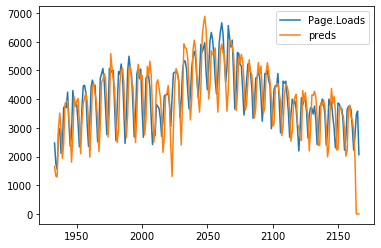

In [55]:
df_ow_es[['Page.Loads', 'preds']].plot()

In [56]:
print("Median-absolute-error", metrics.median_absolute_error(df_ow_es['Page.Loads'], df_ow_es['preds']))

Median-absolute-error 600.5327541051433


In [49]:
df_es = df_test.copy()
df_es['preds'] = 0
p = len(df_test)
model = ExponentialSmoothing(np.asarray(df_train['Page.Loads']),seasonal_periods=365, seasonal='add', trend='add')
model_fit = model.fit()
preds = model_fit.forecast(p)
df_es['preds'] = preds

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


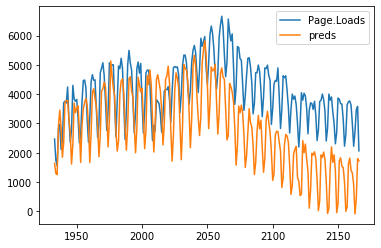

In [50]:
df_es[['Page.Loads', 'preds']].plot()

In [51]:
print("Median-absolute-error", metrics.median_absolute_error(df_es['Page.Loads'], df_es['preds']))

Median-absolute-error 1252.309563681723


In [63]:
df_om_es = rolling_forecast_es(df, df_test, 30)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/ec2-use

0th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2019-12-30 00:00:00
forecast-start-date: 2019-12-30 00:00:00
forecast-end-date: 2020-01-29 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


1th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-01-29 00:00:00
forecast-start-date: 2020-01-29 00:00:00
forecast-end-date: 2020-02-28 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


2th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-02-28 00:00:00
forecast-start-date: 2020-02-28 00:00:00
forecast-end-date: 2020-03-29 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


3th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-03-29 00:00:00
forecast-start-date: 2020-03-29 00:00:00
forecast-end-date: 2020-04-28 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


4th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-04-28 00:00:00
forecast-start-date: 2020-04-28 00:00:00
forecast-end-date: 2020-05-28 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


5th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-05-28 00:00:00
forecast-start-date: 2020-05-28 00:00:00
forecast-end-date: 2020-06-27 00:00:00
6th week
train-start-date: 2014-09-14 00:00:00
train-end-date: 2020-06-27 00:00:00
forecast-start-date: 2020-06-27 00:00:00
forecast-end-date: 2020-07-27 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


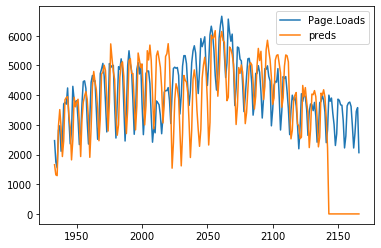

In [64]:
df_om_es[['Page.Loads', 'preds']].plot()

In [65]:
print("Median-absolute-error", metrics.median_absolute_error(df_om_es['Page.Loads'], df_om_es['preds']))

Median-absolute-error 748.9217546543787
